In [9]:
from torch import nn
import matplotlib.pyplot as plt

In [316]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy import signal
from scipy import linalg as la
from scipy import special as ss

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import sys
sys.path.append('C:/Users/faran/Documents_nuova/Documenti/Federico/ETH/in context learning/Git_Hub/In-Context-SSM/model/')
from model.op import transition


"""
The HiPPO_LegT and HiPPO_LegS modules satisfy the HiPPO interface:

The forward() method takes an input sequence f of length L to an output sequence c of shape (L, N) where N is the order of the HiPPO operator.
c[k] can be thought of as representing all of f[:k] via coefficients of a polynomial approximation.

The reconstruct() method takes the coefficients and turns each coefficient into a reconstruction of the original input.
Note that each coefficient c[k] turns into an approximation of the entire input f, so this reconstruction has shape (L, L),
and the last element of this reconstruction (which has shape (L,)) is the most accurate reconstruction of the original input.

Both of these two methods construct approximations according to different measures, defined in the HiPPO paper.
The first one is the "Translated Legendre" (which is up to scaling equal to the LMU matrix),
and the second one is the "Scaled Legendre".
Each method comprises an exact recurrence c_k = A_k c_{k-1} + B_k f_k, and an exact reconstruction formula based on the corresponding polynomial family.
"""

class HiPPO_LegT(nn.Module):
    def __init__(self, N, dt=1.0, discretization='bilinear', trainable=False):
        """
        N: the order of the HiPPO projection
        dt: discretization step size - should be roughly inverse to the length of the sequence
        """
        super().__init__()
        self.N = N
        self.dt = dt
        A, B = transition('legt', N)

        if trainable:
            C = np.ones((N,))
            D = np.zeros((1,))
            self.C_discr = torch.Tensor(C)
            self.D_discr = torch.Tensor(D)

        else:
            Q = np.arange(N, dtype=np.float64)
            evals = (2*Q + 1)** .5  #The Lengendre Polinomyals satisfy P_n(1) = 1 for all n
            evals = np.reshape(evals, (self.N, ))

            C = np.dot(evals, A)
            D = np.sum(evals*B.squeeze(-1)).reshape(1,)

            self.C = torch.Tensor(np.reshape(C, (N, )))
            self.D = torch.Tensor(np.reshape(D, (1,)))

            self.C_discr = 1/(1-0.5*self.D*self.dt)*0.5*dt*self.C
            self.D_discr = 1/(1-0.5*self.D*self.dt)*(1+0.5*dt*self.D)


        # dt, discretization options
        A, B, _, _, _ = signal.cont2discrete((A, B, C, D), dt=dt, method=discretization)

        B = B.squeeze(-1)
    
        self.register_buffer('A', torch.Tensor(A)) # (N, N)
        self.register_buffer('B', torch.Tensor(B)) # (N,)

        # vals = np.linspace(0.0, 1.0, 1./dt)
        vals = np.arange(0.0, 1.0, dt)
        self.eval_matrix = torch.Tensor(ss.eval_legendre(np.arange(N)[:, None], 1 - 2 * vals).T)

    def forward(self, inputs):
        """
        inputs : (batch size, length)
        output : (batch size, length) where N is the order of the HiPPO projection
        """
        if len(inputs.shape) == 1:
            #then batch size is one and we unsqueeze
            inputs = inputs.unsqueeze(0)
            
        inputs = inputs.unsqueeze(-1)
        u = inputs * self.B # (length, ..., N)

        c = torch.zeros((u.shape[0], u.shape[-1]))

        cs = []
        next_step_pred = []
    
        for i in range(inputs.shape[1]):
            c = F.linear(c, self.A) + self.B * inputs[:,i,:]
            if len(cs)==0:
                pred = (c @ self.C_discr).reshape(-1,1) + self.D_discr * inputs[:,i,:]
            else:
                pred = (2*c @ self.C_discr).reshape(-1,1) + self.D_discr * inputs[:,i,:]
            cs.append(c)
            next_step_pred.append(pred)
        
        
        return torch.stack(next_step_pred, dim=1).squeeze(-1)
        #return torch.stack(cs, dim=0)

    def reconstruct(self, c):
        return (self.eval_matrix @ c.unsqueeze(-1)).squeeze(-1)


In [317]:
print("trainable")
model_trainable = HiPPO_LegT(N = 10, trainable=True)
print("____")
print("optparams")
model_opt = HiPPO_LegT(N = 10, trainable=False)

trainable
____
optparams


In [319]:
x = torch.linspace(0,10,200)
x = torch.stack((x, x))
print("x", x.shape)
y = torch.sin(x)
print("y", x.shape)
y_pred = model_trainable(y)
y_pred_opt = model_opt(y)
x.shape, y.shape, y_pred.shape, y_pred_opt.shape

x torch.Size([2, 200])
y torch.Size([2, 200])


(torch.Size([2, 200]),
 torch.Size([2, 200]),
 torch.Size([2, 200]),
 torch.Size([2, 200]))

In [320]:
print(y_pred.shape)

torch.Size([2, 200])


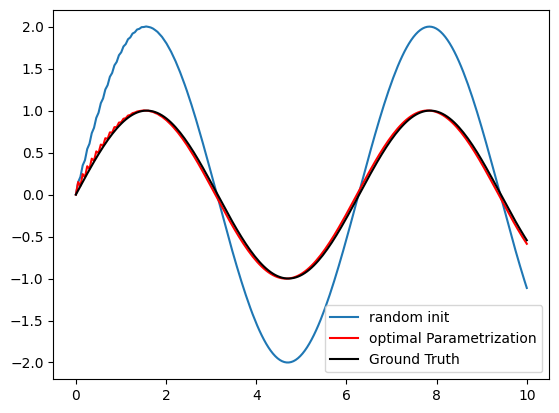

In [333]:
plt.plot(x[0,:], y_pred[0,:], label="random init")
plt.plot(x[0,:], y_pred_opt[0,:], c="red", label="optimal Parametrization")
plt.plot(x[0,:], y[0,:], c="black", label="Ground Truth")
plt.legend()